In [91]:
%matplotlib inline
import matplotlib.pyplot as plt

# basic cnn training
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.utils import multi_gpu_model, to_categorical

import keras
import tensorflow as tf

import numpy as np
import os, sys, errno

import csv
import codecs
import pickle
import h5py
import glob

if len(sys.argv) > 1 and sys.argv[1] == '0':
    prefix = '/mnt_blpc1/datax/scratch/bbrzycki/training/training3/'
else:
    prefix = '/datax/scratch/bbrzycki/training/training3/'

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, num_labels=1, batch_size=32, dim=(32,1024), n_channels=1, n_classes=10, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.num_labels = num_labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, self.num_labels))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            filename = ID
            X[i] = np.load(filename).reshape((*self.dim, self.n_channels))
            
            X[i] -= np.mean(X[i])
            X[i] /= np.std(X[i])

            # Store class
            y[i] = self.labels[ID]
#         y = to_categorical(y)

        return X, y

# dimensions of our images.
img_width, img_height = 32, 1024
                                                                 
tsamp = 1.4316557653333333

dir_name = '/datax/scratch/bbrzycki/training/training3/'

##############################################################

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [92]:
filenames = set(glob.glob(prefix + 'data/test/*sig*rfi*.npy'))
filenames = list(filenames - set(glob.glob(prefix + 'data/test/*sig*rfi*_128x256.npy')))
print(len(filenames))

test_num = len(filenames)

24200


In [93]:
noise_labels = np.load('/datax/scratch/bbrzycki/training/training3/data/test/noise_labels.npy').item()
signal_labels = np.load('/datax/scratch/bbrzycki/training/training3/data/test/signal_labels.npy').item()
frame_param_labels = np.load('/datax/scratch/bbrzycki/training/training3/data/test/frame_param_labels.npy').item()
labels = {fn: frame_params[0] for (fn, frame_params) in frame_param_labels.items()}


In [94]:
i = np.random.randint(test_num)
i

13445

In [20]:
filenames[i]

'/datax/scratch/bbrzycki/training/training3/data/test/09sig_0.6rfi_000173.npy'

In [21]:
labels[filenames[i]]

9

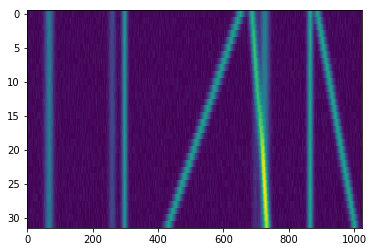

In [22]:
frame = np.load(filenames[i])
plt.imshow(frame, aspect='auto')
plt.show()

In [96]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(32, 1024, 1)))
model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error',
              optimizer='adam')

model.load_weights(prefix + 'models/simple_cnn.h5')

In [97]:

X = frame.reshape((1, 32, 1024, 1))

X -= np.mean(X)
X /= np.std(X)

model.predict(X)

array([[1.1428399]], dtype=float32)

In [29]:
labels[filenames[i]]

9

[[3.2070775]]
3


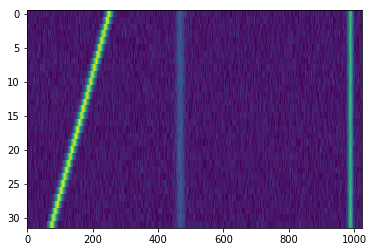

In [55]:
i = np.random.randint(test_num)
frame = np.load(filenames[i])
label = labels[filenames[i]]

X = frame.reshape((1, 32, 1024, 1))

X -= np.mean(X)
X /= np.std(X)

print(model.predict(X))
print(label)

frame = np.load(filenames[i])
plt.imshow(frame, aspect='auto')
plt.show()

In [67]:
np.random.choice(('a', 'b', 'c'), 5)

array(['c', 'b', 'b', 'b', 'a'], dtype='<U1')

In [95]:
predictions = {}
prediction_filenames = np.random.choice(filenames, 1000, replace=False)
for i, fn in enumerate(prediction_filenames):
    frame = np.load(fn)
    label = labels[fn]

    X = frame.reshape((1, 32, 1024, 1))

    X -= np.mean(X)
    X /= np.std(X)
    
    predictions[fn] = model.predict(X)[0][0]

len(predictions)

NameError: name 'model' is not defined

In [81]:
true = []
pred = []

for i, fn in enumerate(prediction_filenames):
    pred.append(round(predictions[fn]))
    true.append(labels[fn])

In [82]:
import sklearn.metrics

In [83]:
sklearn.metrics.accuracy_score(true, pred)

0.75

In [98]:
fn = filenames[i]

In [85]:
total = 0
for i in range(len(true)):
    if abs(round(pred[i]) - true[i]) <= 1:
        total += 1
print(total/len(true))

0.986


In [87]:
labels[fn]

3

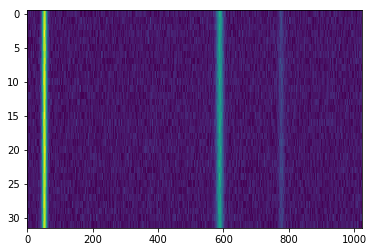

In [89]:
frame = np.load(fn)
plt.imshow(frame, aspect='auto')
plt.show()

In [142]:
# import edited version of turbo_seti
sys.path.insert(1,'/home/bryanb/turbo_seti/')
from turbo_seti.findoppler.findopp import FinDoppler

# This is a hack... necessary to make turbo_seti work?
obs_info = {}
obs_info['pulsar'] = 0  # Bool if pulsar detection.
obs_info['pulsar_found'] = 0  # Bool if pulsar detection.
obs_info['pulsar_dm'] = 0.0  # Pulsar expected DM.
obs_info['pulsar_snr'] = 0.0 # SNR
obs_info['pulsar_stats'] = np.zeros(6)
obs_info['RFI_level'] = 0.0
obs_info['Mean_SEFD'] = 0.0
obs_info['psrflux_Sens'] = 0.0
obs_info['SEFDs_val'] = [0.0]
obs_info['SEFDs_freq'] = [0.0]
obs_info['SEFDs_freq_up'] = [0.0]

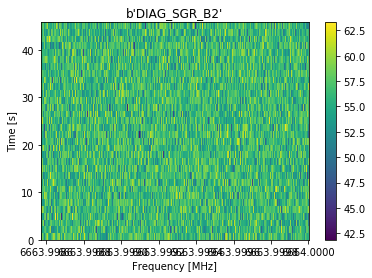

In [99]:
from blimpy import read_header, Waterfall, Filterbank

fil = Waterfall('/home/bryanb/setigen/setigen/assets/sample.fil')
fil.plot_waterfall()

In [100]:
fil.data = np.load(fn)

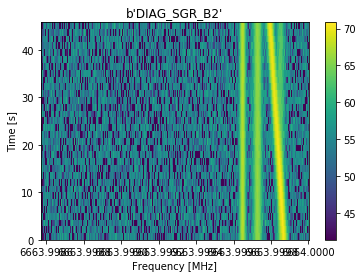

In [101]:
fil.plot_waterfall()

In [103]:
fil.header

{b'machine_id': 20,
 b'telescope_id': 6,
 b'src_raj': <Angle 17.7875 hourangle>,
 b'src_dej': <Angle -28.3831 deg>,
 b'az_start': 0.0,
 b'za_start': 0.0,
 b'data_type': 1,
 b'fch1': 6663.99999987334,
 b'foff': -1.3969838619232178e-06,
 b'nchans': 1024,
 b'nbeams': 1,
 b'ibeam': -1,
 b'nbits': 32,
 b'tstart': 58465.717094907406,
 b'tsamp': 1.431655765333332,
 b'nifs': 1,
 b'source_name': b'DIAG_SGR_B2',
 b'rawdatafile': b'blc13_guppi_58465_61957_DIAG_SGR_B2_0066.0000.raw'}

In [104]:
30 * 1.431655765333332 / 1.3969838619232178

30.744573456182557

In [106]:
1024/32*1.3969838619232178/1.431655765333332

31.22502256758256

In [99]:
fil_fn = fn[:-4] + '.fil'
fil.write_to_fil(fil_fn)

blimpy.waterfall INFO     Conversion time: 0.18sec


In [101]:
find_seti_event = FinDoppler(fil_fn, max_drift=30.0, snr=10, out_dir='/datax/scratch/bbrzycki/turbo', obs_info=obs_info)
find_seti_event.search()

turbo_seti.findoppler.data_handler INFO     File .fil detected. Attempting to create .h5 file in current directory...
blimpy.waterfall WARNING  Warning: bitshuffle not found. No compression applied.
blimpy.waterfall INFO     Conversion time: 0.17sec
blimpy.file_wrapper INFO     Skipping loading data ...
blimpy.file_wrapper INFO     Skipping loading data ...
turbo_seti.findoppler.findopp INFO     {b'DIMENSION_LABELS': array([b'frequency', b'feed_id', b'time'], dtype=object), b'az_start': 0.0, b'data_type': 1, b'fch1': 6663.99999987334, b'foff': -1.3969838619232178e-06, b'ibeam': -1, b'machine_id': 20, b'nbeams': 1, b'nbits': 32, b'nchans': 1024, b'nifs': 1, b'rawdatafile': b'blc13_guppi_58465_61957_DIAG_SGR_B2_0066.0000.raw', b'source_name': b'DIAG_SGR_B2', b'src_dej': <Angle -28.3831 deg>, b'src_raj': <Angle 17.7875 hourangle>, b'telescope_id': 6, b'tsamp': 1.431655765333332, b'tstart': 58465.717094907406, b'za_start': 0.0}
turbo_seti.findoppler.findopp INFO     A new FinDoppler instan

In [108]:
import os
os.path.split(fn)

('/datax/scratch/bbrzycki/training/training3/data/test',
 '03sig_1.0rfi_000136.npy')

In [110]:
import pandas as pd

headers = ['Top_Hit_#', 'Drift_Rate', 'SNR', 'Uncorrected_Frequency', 'Corrected_Frequency', 'Index', 'freq_start', 'freq_end', 'SEFD', 'SEFD_freq', 'Coarse_Channel_Number', 'Full_number_of_hits']

dat_fn = '/datax/scratch/bbrzycki/turbo/' + os.path.split(fn)[1][:-4] + '.dat'
df = pd.read_csv(dat_fn, delim_whitespace=True, comment='#', names=headers)
df

,Top_Hit_#,Drift_Rate,SNR,Uncorrected_Frequency,Corrected_Frequency,Index,freq_start,freq_end,SEFD,SEFD_freq,Coarse_Channel_Number,Full_number_of_hits
0,1,0.0,56.692653,6663.999926,6663.999926,53,6664.0,6663.998968,0.0,0.0,1,9267


In [111]:
len(df)

1

In [112]:
ml_pred = pred

In [ ]:
fil = Waterfall('/home/bryanb/setigen/setigen/assets/sample.fil')

headers = ['Top_Hit_#', 
           'Drift_Rate', 
           'SNR',
           'Uncorrected_Frequency',
           'Corrected_Frequency', 
           'Index', 
           'freq_start', 
           'freq_end',
           'SEFD', 
           'SEFD_freq', 
           'Coarse_Channel_Number', 
           'Full_number_of_hits']

turboseti_pred = []
for fn in prediction_filenames:
    fil.data = np.load(fn)
    save_fil_fn = '/datax/scratch/bbrzycki/turbo/training3/' + os.path.split(fn)[1][:-4] + '.fil'
    fil.write_to_fil(save_fil_fn)
    
    find_seti_event = FinDoppler(save_fil_fn, 
                                 max_drift=30.0, 
                                 snr=10, 
                                 out_dir='/datax/scratch/bbrzycki/turbo/training3/', 
                                 obs_info=obs_info)
    find_seti_event.search()

    dat_fn = save_fil_fn[:-4] + '.dat'
    df = pd.read_csv(dat_fn, delim_whitespace=True, comment='#', names=headers)
    turboseti_pred.append(len(df))
    
    

In [117]:
prediction_filenames = np.load('prediction_filenames.npy')

turboseti_pred = []
for fn in prediction_filenames:
    dat_fn = '/datax/scratch/bbrzycki/turbo/training3/' + os.path.split(fn)[1][:-4] + '.dat'
    df = pd.read_csv(dat_fn, delim_whitespace=True, comment='#', names=headers)
    turboseti_pred.append(len(df['Top_Hit_#'].unique()))
np.save('turboseti_pred.npy', turboseti_pred)

In [118]:
import numpy as np
y_true = np.load('y_true.npy')
ml_pred = np.load('ml_pred.npy')
turboseti_pred = np.load('turboseti_pred.npy')
prediction_filenames = np.load('prediction_filenames.npy')

In [119]:
turboseti_pred.shape

(1000,)

In [15]:
idx = np.where(y_true == 1)
idx[0].shape

(91,)

In [57]:
for i in range(11):
    print(len(np.where(y_true == i)[0]))

102
91
106
104
83
80
82
90
87
84
91


In [59]:
def bins_labels(bins, **kwargs):
    bin_w = (max(bins) - min(bins)) / (len(bins) - 1)
    plt.xticks(np.arange(min(bins)+bin_w/2, max(bins), bin_w), bins, **kwargs)
    plt.xlim(bins[0], bins[-1])
    
bins=range(-1, 13)

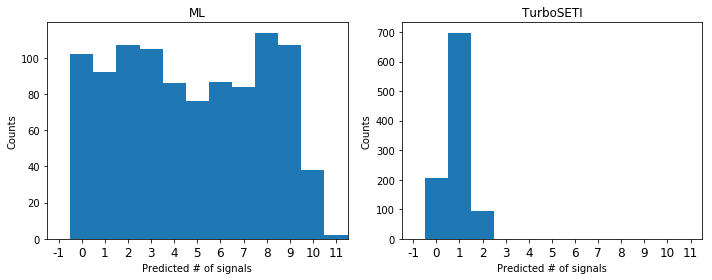

In [120]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(ml_pred, bins=bins)
bins_labels(bins, fontsize=12)
plt.title('ML')
plt.xlabel('Predicted # of signals')
plt.ylabel('Counts')
# plt.ylim(0, 700)

plt.subplot(1, 2, 2)
plt.hist(turboseti_pred, bins=bins)
bins_labels(bins, fontsize=12)
plt.title('TurboSETI')
plt.xlabel('Predicted # of signals')
plt.ylabel('Counts')
# plt.ylim(0, 700)
plt.tight_layout()
plt.savefig('total_prediction_distributions.pdf', bbox_inches='tight')
plt.show()

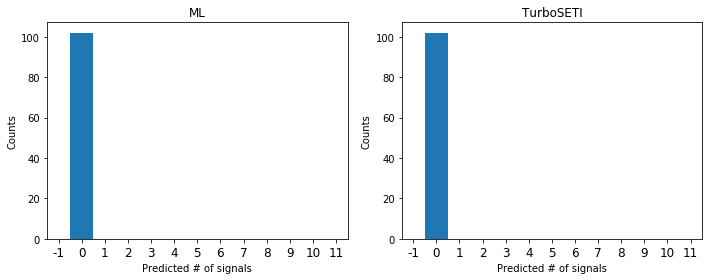

In [125]:
true_signal_number = 0
idx = np.where(y_true == true_signal_number)

fig = plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(ml_pred[idx], bins=bins)
bins_labels(bins, fontsize=12)
plt.title('ML')
plt.xlabel('Predicted # of signals')
plt.ylabel('Counts')

plt.subplot(1, 2, 2)
plt.hist(turboseti_pred[idx], bins=bins)
bins_labels(bins, fontsize=12)
plt.title('TurboSETI')
plt.xlabel('Predicted # of signals')
plt.ylabel('Counts')
plt.tight_layout()
plt.savefig('%d_signal_prediction_distributions.pdf' % true_signal_number, bbox_inches='tight')
plt.show()

In [71]:
((y_true == 10) & (turboseti_pred == 0)).sum()

37

In [73]:
np.where(((y_true == 10) & (turboseti_pred == 0)))

(array([ 24,  66,  92, 136, 161, 224, 319, 328, 356, 360, 398, 400, 473,
        483, 485, 502, 509, 544, 550, 563, 573, 576, 622, 627, 706, 710,
        776, 777, 792, 818, 819, 840, 850, 867, 891, 910, 980]),)

In [74]:
prediction_filenames[24]

'/datax/scratch/bbrzycki/training/training3/data/test/10sig_0.7rfi_000192.npy'

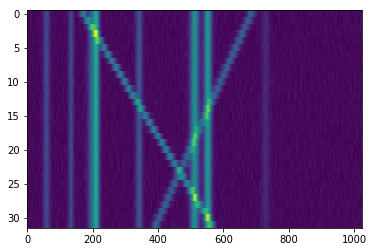

In [75]:
frame = np.load(prediction_filenames[24])
plt.imshow(frame, aspect='auto')
plt.show()

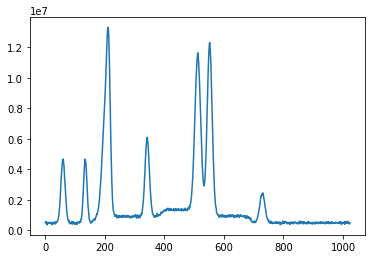

In [77]:
plt.plot(np.mean(frame, axis=0))
plt.show()

In [127]:
np.where(((y_true == 1) & (turboseti_pred == 2)))

(array([  0,  17,  79, 108, 193, 209, 228, 231, 277, 325, 499, 558, 603,
        737, 899, 927, 947]),)

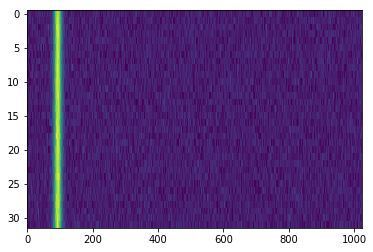

In [128]:
frame = np.load(prediction_filenames[0])
plt.imshow(frame, aspect='auto')
plt.show()

In [129]:
prediction_filenames[0]

'/datax/scratch/bbrzycki/training/training3/data/test/01sig_1.0rfi_000197.npy'

In [133]:
import pandas as pd

headers = ['Top_Hit_#', 'Drift_Rate', 'SNR', 'Uncorrected_Frequency', 'Corrected_Frequency', 'Index', 'freq_start', 'freq_end', 'SEFD', 'SEFD_freq', 'Coarse_Channel_Number', 'Full_number_of_hits']

dat_fn = '/datax/scratch/bbrzycki/turbo/training3/01sig_1.0rfi_000197.dat'
df = pd.read_csv(dat_fn, delim_whitespace=True, comment='#', names=headers)
df.drop_duplicates('Top_Hit_#')

,Top_Hit_#,Drift_Rate,SNR,Uncorrected_Frequency,Corrected_Frequency,Index,freq_start,freq_end,SEFD,SEFD_freq,Coarse_Channel_Number,Full_number_of_hits
0,1,0.00000,160.376589,6663.999870,6663.999870,93,6664.000000,6663.998912,0.0,0.0,1,113428
1,2,4.87891,23.819500,6663.998632,6663.998632,979,6663.999593,6663.998571,0.0,0.0,1,113428


In [138]:
signal_labels[prediction_filenames[0]][0][0:2]*1024

array([94., 94.])

In [139]:
979+94

1073

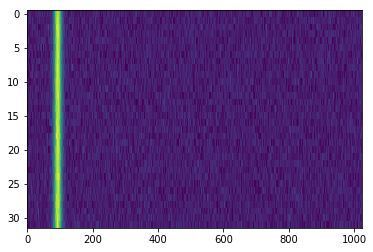

In [140]:
plt.imshow(frame, aspect='auto')


In [143]:
find_seti_event = FinDoppler('/datax/scratch/bbrzycki/turbo/training3/01sig_1.0rfi_000197.fil', 
                             max_drift=30.0, 
                             snr=10, 
                             out_dir='/datax/scratch/bbrzycki/turbo/training3/', 
                             obs_info=obs_info)
find_seti_event.search()

dat_fn = '/datax/scratch/bbrzycki/turbo/training3/01sig_1.0rfi_000197.dat'
df = pd.read_csv(dat_fn, delim_whitespace=True, comment='#', names=headers)
df.drop_duplicates('Top_Hit_#')

turbo_seti.findoppler.data_handler INFO     File .fil detected. Attempting to create .h5 file in current directory...
blimpy.waterfall WARNING  Warning: bitshuffle not found. No compression applied.
blimpy.waterfall INFO     Conversion time: 0.95sec
blimpy.file_wrapper INFO     Skipping loading data ...
blimpy.file_wrapper INFO     Skipping loading data ...
turbo_seti.findoppler.findopp INFO     {b'DIMENSION_LABELS': array([b'frequency', b'feed_id', b'time'], dtype=object), b'az_start': 0.0, b'data_type': 1, b'fch1': 6663.99999987334, b'foff': -1.3969838619232178e-06, b'ibeam': -1, b'machine_id': 20, b'nbeams': 1, b'nbits': 32, b'nchans': 1024, b'nifs': 1, b'rawdatafile': b'blc13_guppi_58465_61957_DIAG_SGR_B2_0066.0000.raw', b'source_name': b'DIAG_SGR_B2', b'src_dej': <Angle -28.3831 deg>, b'src_raj': <Angle 17.7875 hourangle>, b'telescope_id': 6, b'tsamp': 1.431655765333332, b'tstart': 58465.717094907406, b'za_start': 0.0}
turbo_seti.findoppler.findopp INFO     A new FinDoppler instan

,Top_Hit_#,Drift_Rate,SNR,Uncorrected_Frequency,Corrected_Frequency,Index,freq_start,freq_end,SEFD,SEFD_freq,Coarse_Channel_Number,Full_number_of_hits
0,1,0.00000,160.376589,6663.999870,6663.999870,93,6664.000000,6663.998912,0.0,0.0,1,113428
1,2,4.87891,23.819500,6663.998632,6663.998632,979,6663.999593,6663.998571,0.0,0.0,1,113428


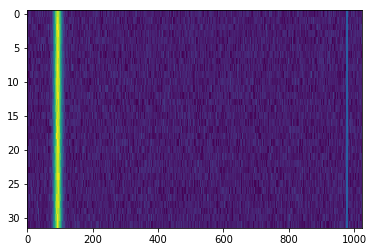

In [144]:
plt.imshow(frame, aspect='auto')

plt.axvline(x=979)
plt.plot()
plt.show()

In [146]:
979+160-93

1046